In [12]:
import arviz
import cmdstanpy
from functools import reduce
from IPython.display import display, YouTubeVideo
from matplotlib import pyplot as plt
from numbers import Number
import numpy as np
import os
import pandas as pd
from pandas.io.json import json_normalize
import toml
import reaction_network
plt.style.use('sparse.mplstyle')

# Modelling networks of metabolic reactions with Stan

Many useful substances can be produced using chemical reactions that happen inside living organisms like [_E. Coli_](https://en.wikipedia.org/wiki/Escherichia_coli), [yeast](https://en.wikipedia.org/wiki/Yeast) or [Chinese hamster ovary cells](https://en.wikipedia.org/wiki/Chinese_hamster_ovary_cell). Biological production is appealing because it can be done in relatively mild conditions. On the other hand, biological production depends on complex networks of interacting chemical reactions catalysed by enzymes with intricate mechanisms, all of which can be difficult to understand, manipulate and optimise.

This notebook describes how to use Bayesian inference to integrate different sources of information about metabolic reaction networks, namely structural information about the topology of a reaction network and the mechanisms of its enzymes, quantitative information gleaned from online databases and information from _in vivo_ measurements of enzyme concentrations, metabolite concentrations and reaction rates carried out in different conditions.

## Wait, what is an enzyme-catalysed reaction?
An enzyme is a 'catalyst' protein that speeds up a chemical reaction by binding the reactants to an 'active site' where the conditions for the reaction are favourable. This visualisation gives an idea of how this process is thought to work: 

![Enzyme Action and the Hydrolysis of Sucrose [HD Animation]](https://i.makeagif.com/media/9-16-2015/SIif27.gif)


For more about enzymes, check out this great video:

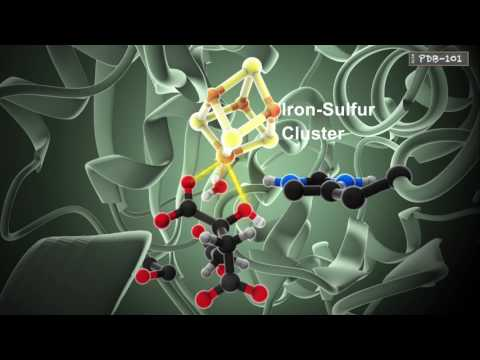

In [13]:
YouTubeVideo('yk14dOOvwMk')

## Structural information 

The topological structure of some well-studied metabolic networks have been mapped. In these cases it is is known which metabolites go in and out of each reaction and which enzyme catalyses it. This information is available online, for example in the [BIGG database](http://bigg.ucsd.edu/). 

Here is a reduced map of yeast central carbon metabolism, with nodes representing metabolites and edges representing reactions: 

<img src="img/yeast_central_metabolism.png" alt="Drawing" style="width: 600px;"/>

Finer-grained structural information can be used to deduce the mechanism by which each enzyme operates. A mechanism, in turn, implies a way of parameterising the rate at which an enzyme turns substrates into products. 

The diagram below shows the elementary mechanism of the enzyme [enolase](https://en.wikipedia.org/wiki/Enolase) (ENO), which catalyses a reaction that turns 2-phospho-D-glycerate (2PG) into phosphoenolpyruvate (PEP).

<img src="img/uniuni_fig2.png" alt="Drawing" style="width: 300px;"/>

This mechanism is generally called 'uni-uni' (with no activators or inhibitors) and its rate $v$ can be parametereised as follows, as depending on the current concentration of the substrate $A$ and product $P$, as well as parameters $K_{eq}$, $K_{a}$, $V1$ and $V2$:

$$
\begin{equation}
v = \frac{V1\cdot{V2}\cdot{(A-P/K_{eq})}}{K_{a}\cdot{V2} + V2\cdot{A} + V1\cdot{P/K_{eq}}}
\end{equation}
$$

See [Cleland (1963)](https://doi.org/10.1016/0926-6569%2863%2990211-6) for more about mechanisms in general and derivations of particular mechanisms used in this analysis.


## Information from online databases
Many kinetic parameters are difficult to assess in isolation because the conditions inside a cell are difficult to replicate _in vitro_. See [Saa and Keld Nielsen (2017)](https://doi.org/10.1016/j.biotechadv.2017.09.005) for more about this issue. Nonetheless, a lot of information is available.

For kinetic parameters it is possible to use the 'Respectful' modelling paradigm (see [Tsigkinopoulou, Baker, and Breitling (2017)](https://doi.org/10.1016/j.tibtech.2016.12.008)) to aggregate the results of findings about kinetic parameters published in the [BRENDA enzyme database](https://www.brenda-enzymes.org/), as well as assessments of thermodynamic parameters from the [equilibrator database](http://equilibrator.weizmann.ac.il/). This analysis produces an independent normal or log-normal distribution representing the online information available about each parameter.

## Experimental information

We aim to take into account data from the following experimental techniques measure the following quantities:

- Enzyme concentrations (_proteomics_)
- Metabolite concentrations (_metabolomics_)
- Rates of reactions, aka fluxes (_fluxomics_)

Each kind of measurement is inaccurate. The noise in metabolomics and proteomics data is roughly proportional to the value of the measurement, whereas in the case of fluxomics data the noise is additive.

## Modelling strategy

We are proposing to use Bayesian inference to combine all the available sources of information about a metabolic network.

The 'respectful' pipeline turns information from online databases into more or less informative prior probability distributions about the parameters that describe each reaction.

We treat information from metabolomics and fluxomics data using a regression model where recorded values of measured quantities are draws from distributions centered on the true values as follows, with indexes $e$ standing for experiments, $f$ for fluxes and $m$ for metabolites:

$$
measured\, flux_{f,e} \sim Normal(true\, flux_{f,e}, \sigma_{f,e}) \\
measured\, metabolite\, concentration_{m,e} \sim Lognormal(\log(true\, metabolite\, concentration_{m,e}), \sigma_{m,e})
$$

Proteomics data about enzyme concentrations is assumed to be precisely accurate (we will seek to relax this assumption in future work).

Structural information can be used to connect the metabolomics and fluxomics data with the priors by mapping parameter configurations to true metabolite concentrations and fluxes. This is done by expressing the evolution of each metabolite's concentration as a system of ordinary differential equations, with the rate of change of each metabolite determined by the rates of the reactions that produce and consume it. We assume that, at the time of measurement, the concentration of the network's internal metabolites is constant, or in other words that the system has reached a steady state. In general, a vector $\mathbf{v}$ of steady state fluxes must satisfy the following condition

$$
S\cdot\mathbf{v} = \mathbf{0}
$$

Where $S$ is a known 'stoichiometric matrix' indicating which reactions produce and consume which metabolites and $\mathbf{0}$ is a vector of as many zeros as the network has internal metabolites. Given a parameter configuration, a steady state metabolite concentration can be found by solving the resulting system of algebraic equations. 

We solve these equation systems by integrating the implied ODEs over a period of time for which it is safe to assume that the system has reached steady state.

This approach is essentially the same as that set out by [Saa and Keld Nielsen (2016)](https://doi.org/10.1038/srep29635), but uses MCMC via Stan rather than rejection sampling to make inferences. Thanks to Stan's intuitive model language, this approach and attendant assumptions can be represented in a more or less self-documenting form.


## Example - a simple reaction network

The rest of the notebook applies this modelling strategy to investigate how accurately it is possible to find out the value of the kinetic parameters and steady state metabolite concentrations of the simple metabolic network depicted below, given a known experimental setup and prior information.

<img src="img/toy_model_pic.png" alt="Drawing" style="width: 800px;"/>

This network has four internal metabolites, M1-4, and six reactions R1-6. Metabolites M2, M3 and M4 are measured, and reaction R1 is inhibited by M4. The metabolites with 'ex' in their names are external, and are modelled differently as they are not assumed to have constant concentrations at steady state.

To gauge how accurately the available information identifies the quantities of interest, the notebook uses Stan to generate simulated experimental data given 'true' parameter values, then uses the simulated data as model input. If the model is unable to recover the true value of a parameter, this is may be a sign that the simulated experiment shouldn't be carried out in real life without more diverse or accurate measurements or better pre-experimental information.

## Model input
We are developing an input data format for succinctly expressing the information required to model a metabolic network. Here is what the linear system looks like in this format:

In [2]:
with open('toy.toml', 'r') as f:
    print(f.read())

[constants]
gas_constant = 8.314e-3 # units kJ/mol.K

[[experiment]]
label = 'condition_1'
concentration_r1 = 1
concentration_r2 = 1.5
concentration_r3 = 2
concentration_r4 = 1.5
concentration_r5 = 1.5
concentration_r6 = 1
unbalanced_metabolite_priors = [
  { label = 'M1_ex', loc = 1, scale = 0.4, true_value = 3.27 },
  { label = 'M2_ex', loc = 0, scale = 0.4, true_value = 0.89 },
  { label = 'M4_ex', loc = 0, scale = 0.4, true_value = 1.49 }
]
measurements = [
  # { label = 'M1', value = 2.26, scale = 0.1, type = 'metabolite' },
  { label = 'M2', value = 1.56, scale = 0.05, type = 'metabolite' },
  { label = 'M3', value = 1.07, scale = 0.05, type = 'metabolite' },
  { label = 'M4', value = 3.41, scale = 0.05, type = 'metabolite' },
  { label = 'r1', value = 0.14, scale = 0.05, type = 'flux' }
]

[[experiment]]
label = 'condition_2'
concentration_r1 = 1
concentration_r2 = 1
concentration_r3 = 1
concentration_r4 = 1
concentration_r5 = 1
concentration_r6 = 1
unbalanced_metabolite_priors 

The `reaction` entries in this file jointly specify the network's stoichiometry, reaction mechanisms, priors and allosteric interactions, while the `experiment` entries describe how the system has been measured, including experimental conditions, measured quantities and accuracies of each measurement. A value for each measurement can also be specified, but here we will simulate these using the specified parameter `true_value`s. It is assumed that all experiments were carried out at the same temperature.

### Stan implementation
The next few cells illustrate the Stan code that we wrote to implement the modelling strategy described above.

#### Allosteric regulation

Allosteric effects occur when an enzyme molecule's shape changes due to substances binding to it, making the enzyme a more or less effective catalyst. Allosteric effects play an important role in regulating metabolic reactions. Following [Popova and Selkov (1975)](https://doi.org/10.1016/0014-5793(75)80034-2), we model allosteric regulation through a function that expresses the overall effect of allosteric factors on the rate of a reaction as a multiplicative factor. Here is what the function looks like in Stan code:

In [3]:
with open('stan_code/allostery.stan', 'r') as f:
    print(f.read())

real get_free_enzyme_ratio_uniuni(real A, real P, real V1, real V2, real Ka, real Keq){
  real Kp = Keq * V2 * Ka / V1;
  return 1 / (1 + A/Ka + P/Kp);
}
real get_regulatory_effect(real[] activator_concentration,
                           real[] inhibitor_concentration,
                           real free_enzyme_ratio,
                           real[] dissociation_constant_r,
                           real[] dissociation_constant_t,
                           real transfer_constant){
  real Q_num = size(inhibitor_concentration) == 0 ? 1 :
    1 + sum(to_vector(inhibitor_concentration) ./ to_vector(dissociation_constant_t));
  real Q_denom = size(activator_concentration) == 0 ? 1
    : 1 + sum(to_vector(activator_concentration) ./ to_vector(dissociation_constant_r));
  real Q = transfer_constant * free_enzyme_ratio * Q_num / Q_denom;
  return inv(1 + Q); 
}
    



#### Rate equations

The following Stan functions describe the catalytic effects of each reaction mechanism that appears in the network we want to analyse

In [4]:
with open('stan_code/rate_equations.stan', 'r') as f:
    print(f.read())

real uniuni(real A, real P, real V1, real V2, real Ka, real Keq){
  real num = V1*V2*(A-P/Keq);
  real denom = Ka*V2 + V2*A + V1*P/Keq;
  return num / denom;
}
real ordered_unibi(real A, real P, real Q,
                   real V1, real V2,
                   real Ka, real Kp, real Kq,
                   real Kia, real Kip, real Kiq,
                   real Keq){
  real num = V1*V2*(A-P*Q/Keq); 
  real denom =
    Ka*V2
    + V2*A
    + Kq*V1*P/Keq
    + Kp*V1*Q/Keq
    + V1*P*Q/Keq
    + V2*A*P/Kip;
  return num / denom;
}
real irr_mass_action(real A, real V1){
  return(A*V1);
}
real fixed_flux(real f){
  return f;
}



#### Thermodynamics



#### Inference

The model for making inferences is shown below. The `functions` block uses the library functions described above to define an ode function called `steady_state_equation`. This function is called in the `transformed parameters` block in order to obtain metabolite concentrations given parameter values. In the `model` block the values of the variable `metabolite_concentration` are used in the measurement model.




In [5]:
with open('stan_code/inference_model_toy.stan', 'r') as f:
    print(f.read())

functions {
#include rate_equations.stan
#include haldane_relationships.stan
#include allostery.stan
real [] get_fluxes(real[] metabolites, real[] params, real[] known_reals){  
    real r2_Kip = get_Kip_ordered_unibi(params[5], params[11], params[10], params[6], params[7]);
    real r2_Kiq = get_Kiq_ordered_unibi(params[5], params[8], params[9], params[6], params[7]);

  

  return{   
      uniuni(metabolites[2], metabolites[1], known_reals[1]*params[2], known_reals[1]*params[3], params[4], params[1]),
      ordered_unibi(metabolites[1], metabolites[3], metabolites[4], known_reals[2]*params[6], known_reals[2]*params[7], params[8], params[9], params[10], params[11], r2_Kip, r2_Kiq, params[5]),
      uniuni(metabolites[4], metabolites[5], known_reals[3]*params[13], known_reals[3]*params[14], params[15], params[12]),
      uniuni(metabolites[5], metabolites[6], known_reals[4]*params[17], known_reals[4]*params[18], params[19], params[16]),
      uniuni(metabolites[3], metabolites[7], kno

#### Simulation
A separate simulation model, shown below, is used to generate measurement values. It has the same `functions` block as the inference model, but does not do any MCMC as no uncertainty needs to be taken into account.

In [6]:
with open('stan_code/simulation_model_toy.stan', 'r') as f:
    print(f.read())

functions {
#include rate_equations.stan
#include haldane_relationships.stan
#include allostery.stan
real [] get_fluxes(real[] metabolites, real[] params, real[] known_reals){  
    real r2_Kip = get_Kip_ordered_unibi(params[5], params[11], params[10], params[6], params[7]);
    real r2_Kiq = get_Kiq_ordered_unibi(params[5], params[8], params[9], params[6], params[7]);

  

  return{   
      uniuni(metabolites[2], metabolites[1], known_reals[1]*params[2], known_reals[1]*params[3], params[4], params[1]),
      ordered_unibi(metabolites[1], metabolites[3], metabolites[4], known_reals[2]*params[6], known_reals[2]*params[7], params[8], params[9], params[10], params[11], r2_Kip, r2_Kiq, params[5]),
      uniuni(metabolites[4], metabolites[5], known_reals[3]*params[13], known_reals[3]*params[14], params[15], params[12]),
      uniuni(metabolites[5], metabolites[6], known_reals[4]*params[17], known_reals[4]*params[18], params[19], params[16]),
      uniuni(metabolites[3], metabolites[7], kno

### Modelling

The next cell uses the `true_value` entries from the input data to simulate some measurement values.

In [7]:
STEADY_STATE_TIME = 200
ABS_TOL = 1e-12
REL_TOL = 1e-13
MAX_STEPS = int(1e9)
SIMULATION_CSV_PATH = 'output_data/simulation_output_toy.csv'
SIMULATION_MODEL_FILE = 'stan_code/simulation_model_toy.stan'

rn = reaction_network.load_from_toml('toy.toml')

print('\nUnbalanced metabolite priors:')
display(rn.unbalanced_metabolite_priors)
print('\nkinetic parameter input')
display(rn.kinetic_parameters)

metabolites = rn.metabolites
metabolite_names = rn.stoichiometry.columns
unbalanced_metabolites = rn.metabolites.query('is_unbalanced')
balanced_metabolites = rn.metabolites.query('~is_unbalanced')
reaction_names = rn.stoichiometry.index
concentration_unbalanced = (
    rn.unbalanced_metabolite_priors
    .set_index(['metabolite_code', 'experiment_code'])
    ['true_value']
    .unstack()
    .values
    .tolist()
)
simulation_input_data = {
    'N_balanced': len(balanced_metabolites),
    'N_unbalanced': len(unbalanced_metabolites),
    'N_kinetic_parameter': len(rn.kinetic_parameters),
    'N_reaction': len(reaction_names),
    'N_experiment': len(rn.experiments),
    'N_known_real': len(rn.known_reals),
    'N_flux_measurement': len(rn.flux_measurements),
    'N_concentration_measurement': len(rn.concentration_measurements),
    'pos_balanced': balanced_metabolites['stan_code'].values,
    'pos_unbalanced': unbalanced_metabolites['stan_code'].values,
    'ix_experiment_concentration_measurement': rn.concentration_measurements['experiment_code'].values,
    'ix_experiment_flux_measurement': rn.flux_measurements['experiment_code'].values,
    'ix_metabolite_concentration_measurement': rn.concentration_measurements['metabolite_code'].values,
    'ix_reaction_flux_measurement': rn.flux_measurements['reaction_code'].values,
    'flux_measurement_scale': rn.flux_measurements['scale'].values,
    'concentration_measurement_scale': rn.concentration_measurements['scale'].values,
    'kinetic_parameter': rn.kinetic_parameters['true_value'].values,
    'concentration_unbalanced': concentration_unbalanced,
    'known_reals': rn.known_reals.drop('stan_code', axis=1).values.tolist(),
    'initial_time': 0,
    'steady_time': STEADY_STATE_TIME,
    'rel_tol': REL_TOL,
    'abs_tol': ABS_TOL,
    'max_steps': MAX_STEPS
}

model = cmdstanpy.Model(stan_file=SIMULATION_MODEL_FILE)
model.compile(include_paths=['stan_code'])
    
stanfit = model.sample(
    data=simulation_input_data,
    csv_basename=SIMULATION_CSV_PATH,
    adapt_engaged=False,
    warmup_iters=0,
    sampling_iters=1,
    chains=1,
    cores=1
)

simulated_concentration_measurements = (
    rn.concentration_measurements[['metabolite_label', 'experiment_label']]
    .rename(columns={'metabolite_label': 'metabolite', 'experiment_label': 'experiment'})
    .assign(
        simulated_measurement=stanfit.get_drawset(['simulated_concentration_measurement']).iloc[0].values
    )
    .round(2)
)
simulated_flux_measurements = (
    rn.flux_measurements[['flux_label', 'experiment_label']]
    .rename(columns={'flux_label': 'reaction', 'experiment_label': 'experiment'})
    .assign(
        simulated_measurement=stanfit.get_drawset(['simulated_flux_measurement']).iloc[0].values
    )
    .round(2)

)

print('\nSimulation output:')
display(simulated_concentration_measurements)
display(simulated_flux_measurements)


Unbalanced metabolite priors:


,metabolite,loc,scale,true_value,experiment_label,metabolite_code,experiment_code
0,M1_ex,1,0.4,3.27,condition_1,2,1
1,M2_ex,0,0.4,0.89,condition_1,7,1
2,M4_ex,0,0.4,1.49,condition_1,6,1
3,M1_ex,1,0.4,2.43,condition_2,2,2
4,M2_ex,0,0.4,1.13,condition_2,7,2
5,M4_ex,0,0.4,0.56,condition_2,6,2



kinetic parameter input


,parameter,loc,scale,type,true_value,metabolite,reaction,is_allosteric,label,stan_code
0,Keq,0.0,0.2,thermodynamic,0.93,NaN,r1,0,r1_Keq,1
1,Kcat1,1.1,0.3,kinetic,2.61,NaN,r1,0,r1_Kcat1,2
2,Kcat2,-1.0,1.0,kinetic,1.03,NaN,r1,0,r1_Kcat2,3
3,Ka,0.0,0.5,kinetic,0.80,NaN,r1,0,r1_Ka,4
4,dissociation_constant_t,0.0,0.6,allosteric,1.11,M4,r1,1,r1_dissociation_constant_t_M4,5
5,transfer_constant,0.0,0.6,allosteric,0.71,NaN,r1,1,r1_transfer_constant,6
6,Keq,2.0,0.6,thermodynamic,2.19,NaN,r2,0,r2_Keq,7
7,Kcat1,0.5,0.5,kinetic,4.72,NaN,r2,0,r2_Kcat1,8
8,Kcat2,0.2,0.5,kinetic,0.64,NaN,r2,0,r2_Kcat2,9
9,Ka,0.6,0.4,kinetic,2.51,NaN,r2,0,r2_Ka,10


INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/tedgro/Code/stancon_2019_metabolic_network_notebook/stan_code/simulation_model_toy
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1



Simulation output:


,metabolite,experiment,simulated_measurement
0,M2,condition_1,1.25
1,M3,condition_1,2.01
2,M4,condition_1,6.42
4,M2,condition_2,1.50
5,M3,condition_2,1.09
6,M4,condition_2,2.61


,reaction,experiment,simulated_measurement
3,r1,condition_1,0.11
7,r1,condition_2,0.09


### Sampling given simulated measurements

The next cell uses cmdstanpy to sample from the model, once ignoring the data for prior predictive checks and once using values simulated above.


In [8]:
INFERENCE_MODEL_FILE = 'stan_code/inference_model_toy.stan'

# Initialise and compile model
inference_model = cmdstanpy.Model(stan_file=INFERENCE_MODEL_FILE)
inference_model.compile(include_paths=['stan_code'])

# Define inputs for prior and posterior and save them as json files 
unbalanced_loc, unbalanced_scale = (
    rn.unbalanced_metabolite_priors
    .set_index(['metabolite_code', 'experiment_code'])
    [col]
    .unstack()
    .values
    .tolist()
    for col in ['loc', 'scale']
)

inference_input_prior = {
    'N_balanced': len(balanced_metabolites),
    'N_unbalanced': len(unbalanced_metabolites),
    'N_kinetic_parameter': len(rn.kinetic_parameters),
    'N_reaction': len(reaction_names),
    'N_experiment': len(rn.experiments),
    'N_known_real': len(rn.known_reals),
    'N_flux_measurement': len(rn.flux_measurements),
    'N_concentration_measurement': len(rn.concentration_measurements),
    'pos_balanced': balanced_metabolites['stan_code'].values,
    'pos_unbalanced': unbalanced_metabolites['stan_code'].values,
    'ix_experiment_concentration_measurement': rn.concentration_measurements['experiment_code'].values,
    'ix_experiment_flux_measurement': rn.flux_measurements['experiment_code'].values,
    'ix_metabolite_concentration_measurement': rn.concentration_measurements['metabolite_code'].values,
    'ix_reaction_flux_measurement': rn.flux_measurements['reaction_code'].values,
    
    # Simulated measurements used here
    'flux_measurement': simulated_flux_measurements['simulated_measurement'].values,
    'concentration_measurement': simulated_concentration_measurements['simulated_measurement'].values,
    
    'flux_measurement_scale': rn.flux_measurements['scale'].values,
    'concentration_measurement_scale': rn.concentration_measurements['scale'].values,
    'prior_location_kinetic_parameter': rn.kinetic_parameters['loc'].values,
    'prior_scale_kinetic_parameter': rn.kinetic_parameters['scale'].values,
    'prior_location_unbalanced': unbalanced_loc,
    'prior_scale_unbalanced': unbalanced_scale,
    'known_reals': rn.known_reals.drop('stan_code', axis=1).values.tolist(),
    'initial_time': 0,
    'steady_time': STEADY_STATE_TIME,
    'rel_tol': REL_TOL,
    'abs_tol': ABS_TOL,
    'max_steps': MAX_STEPS,
    'LIKELIHOOD': 0
}
inference_input_posterior = inference_input_prior.copy()
inference_input_posterior['LIKELIHOOD'] = 1

here = os.path.abspath('')
inference_input_file_prior = os.path.join(here, 'output_data/inference_input_data_prior.json')
inference_input_file_posterior = os.path.join(here, 'output_data/inference_input_data_posterior.json')
cmdstanpy.utils.jsondump(inference_input_file_prior, inference_input_prior)
cmdstanpy.utils.jsondump(inference_input_file_posterior, inference_input_posterior)

# Generate samples
inference_csv_basename_prior = os.path.join(here, 'output_data/inference_output_toy_prior.csv')
inference_csv_basename_posterior = os.path.join(here, 'output_data/inference_output_toy_posterior.csv')

stanfit_prior = inference_model.sample(
    data=inference_input_file_prior,
    csv_basename=inference_csv_basename_prior,
    warmup_iters=200,
    sampling_iters=100,
    chains=2,
    cores=2,
    save_warmup=True
)
stanfit_posterior = inference_model.sample(
    data=inference_input_file_posterior,
    csv_basename=inference_csv_basename_posterior,
    warmup_iters=200,
    sampling_iters=100,
    chains=2,
    cores=2,
    save_warmup=True
)

# Display summaries
display(stanfit_prior.summary())
display(stanfit_posterior.summary())
    
shared_arviz_kwargs = dict(
    posterior_predictive=[
        'simulated_flux_measurement', 
        'simulated_concentration_measurement'
    ],
    observed_data={
        'simulated_flux_measurement': inference_input_posterior['flux_measurement'],
        'simulated_concentration_measurement': inference_input_posterior['concentration_measurement']
    },
    coords={
        'reactions': reaction_names,
        'metabolites': metabolite_names,
        'experiments': [x['label'] for x in rn.experiments],
        'parameter_names':  (
        [f'{x}.{y}' for x, y in zip(rn.kinetic_parameters['reaction'], rn.kinetic_parameters['parameter'])]
        ),
        'flux_measurements': (
            [f'{x}.{y}' for x, y in zip(rn.flux_measurements['flux_label'], rn.flux_measurements['experiment_label'])]
        ),
        'concentration_measurements': (
            [f'{x}.{y}' for x, y in zip(rn.concentration_measurements['metabolite_label'], rn.concentration_measurements['experiment_label'])]
        )
    },
    dims={
        'concentration': ['metabolites', 'experiments'],
        'flux': ['reactions', 'experiments'],
        'kinetic_parameter': ['parameter_names'],
        'simulated_concentration_measurement': ['concentration_measurements'],
        'simulated_flux_measurement': ['flux_measurements'],

    }
)
infd_prior = arviz.from_cmdstanpy(stanfit_prior, **shared_arviz_kwargs)
infd_posterior = arviz.from_cmdstanpy(stanfit_posterior, **shared_arviz_kwargs)

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/tedgro/Code/stancon_2019_metabolic_network_notebook/stan_code/inference_model_toy
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-18.266100,1.260700,3.880320,-2.577610e+01,-1.825990e+01,-12.434600,9.47349,0.080685,1.060470
kinetic_parameter[1],1.051110,0.016579,0.217332,7.519780e-01,1.037420e+00,1.482820,171.84000,1.463540,0.994312
kinetic_parameter[2],3.129150,0.061664,0.919303,1.770690e+00,3.092370e+00,4.881450,222.25300,1.892900,1.002010
kinetic_parameter[3],0.617339,0.054588,0.703207,6.079590e-02,3.470700e-01,2.134550,165.95100,1.413380,1.019720
kinetic_parameter[4],1.163300,0.041869,0.672602,4.241250e-01,9.892860e-01,2.431600,258.07000,2.197950,0.999607
kinetic_parameter[5],1.247760,0.044823,0.790275,4.102630e-01,1.060320e+00,2.778140,310.85800,2.647530,0.993024
kinetic_parameter[6],1.307360,0.060432,0.790771,3.706250e-01,1.136230e+00,2.855280,171.22800,1.458330,0.993980
kinetic_parameter[7],9.007580,0.397691,6.130970,2.925720e+00,7.307980e+00,20.479700,237.66600,2.024170,0.999449
kinetic_parameter[8],1.803170,0.044809,0.879830,7.187160e-01,1.665890e+00,3.402280,385.54300,3.283620,0.993228


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-2.275730e+01,4.285310e-01,4.290240e+00,-3.026360e+01,-2.225850e+01,-1.645250e+01,100.2310,0.070429,1.020720
kinetic_parameter[1],1.025450e+00,1.224160e-02,2.020780e-01,7.050010e-01,9.986500e-01,1.377230e+00,272.4950,0.191473,0.995795
kinetic_parameter[2],3.205440e+00,8.089950e-02,1.265860e+00,1.586390e+00,2.974080e+00,5.168530e+00,244.8390,0.172041,0.997028
kinetic_parameter[3],4.533010e-01,3.094270e-02,4.698310e-01,5.846390e-02,2.884200e-01,1.301220e+00,230.5510,0.162001,0.993179
kinetic_parameter[4],1.124480e+00,3.374340e-02,5.588290e-01,4.590070e-01,1.006270e+00,2.252240e+00,274.2710,0.192721,0.990442
kinetic_parameter[5],1.204060e+00,2.988200e-02,4.413840e-01,6.080820e-01,1.104860e+00,1.888050e+00,218.1790,0.153308,1.003430
kinetic_parameter[6],1.268450e+00,6.020050e-02,9.927070e-01,3.075320e-01,1.012450e+00,3.160480e+00,271.9200,0.191070,0.997864
kinetic_parameter[7],8.612340e+00,4.288740e-01,6.223150e+00,2.023700e+00,7.114280e+00,1.847010e+01,210.5530,0.147948,1.018530
kinetic_parameter[8],1.900580e+00,1.366220e-01,1.193040e+00,6.431190e-01,1.580080e+00,4.012920e+00,76.2558,0.053582,1.027860


### Model checking
From the summary and lack of warnings from the diagnostic function we can see that the chains have mixed pretty well and that there were no post-warmup divergent transitions. From the summary of the `metabolite_flux` variables shows that these were mostly very close to zero, indicating that the system reached steady state in most iterations.


### Analysis
In order to ascertain whether the simulated experimental apparatus is powerful enough for it to learn about the network's parameters, we can look at each parameter's marginal prior and posterior distribution. If the model has learned about the parameter then there should be more probability mass around the true value in the marginal posterior distribution than in the prior.

This cell uses the analysis package [arviz](https://arviz-devs.github.io/arviz/index.html) to plot some quantiles of each parameter's marginal prior and posterior distribution alongside the true value that was fed into the simulation.

For some parameters we can see that the marginal posterior concentrates more closely around the true value than the marginal prior distribution. For other parameters this is not the case. Depending on which parameters we care most about, this test could help determine whether or not to carry out additional experiments, or not to carry out the analysis in the first place.

/Users/tedgro/Code/stancon_2019_metabolic_network_notebook/venv/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/Users/tedgro/Code/stancon_2019_metabolic_network_notebook/venv/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


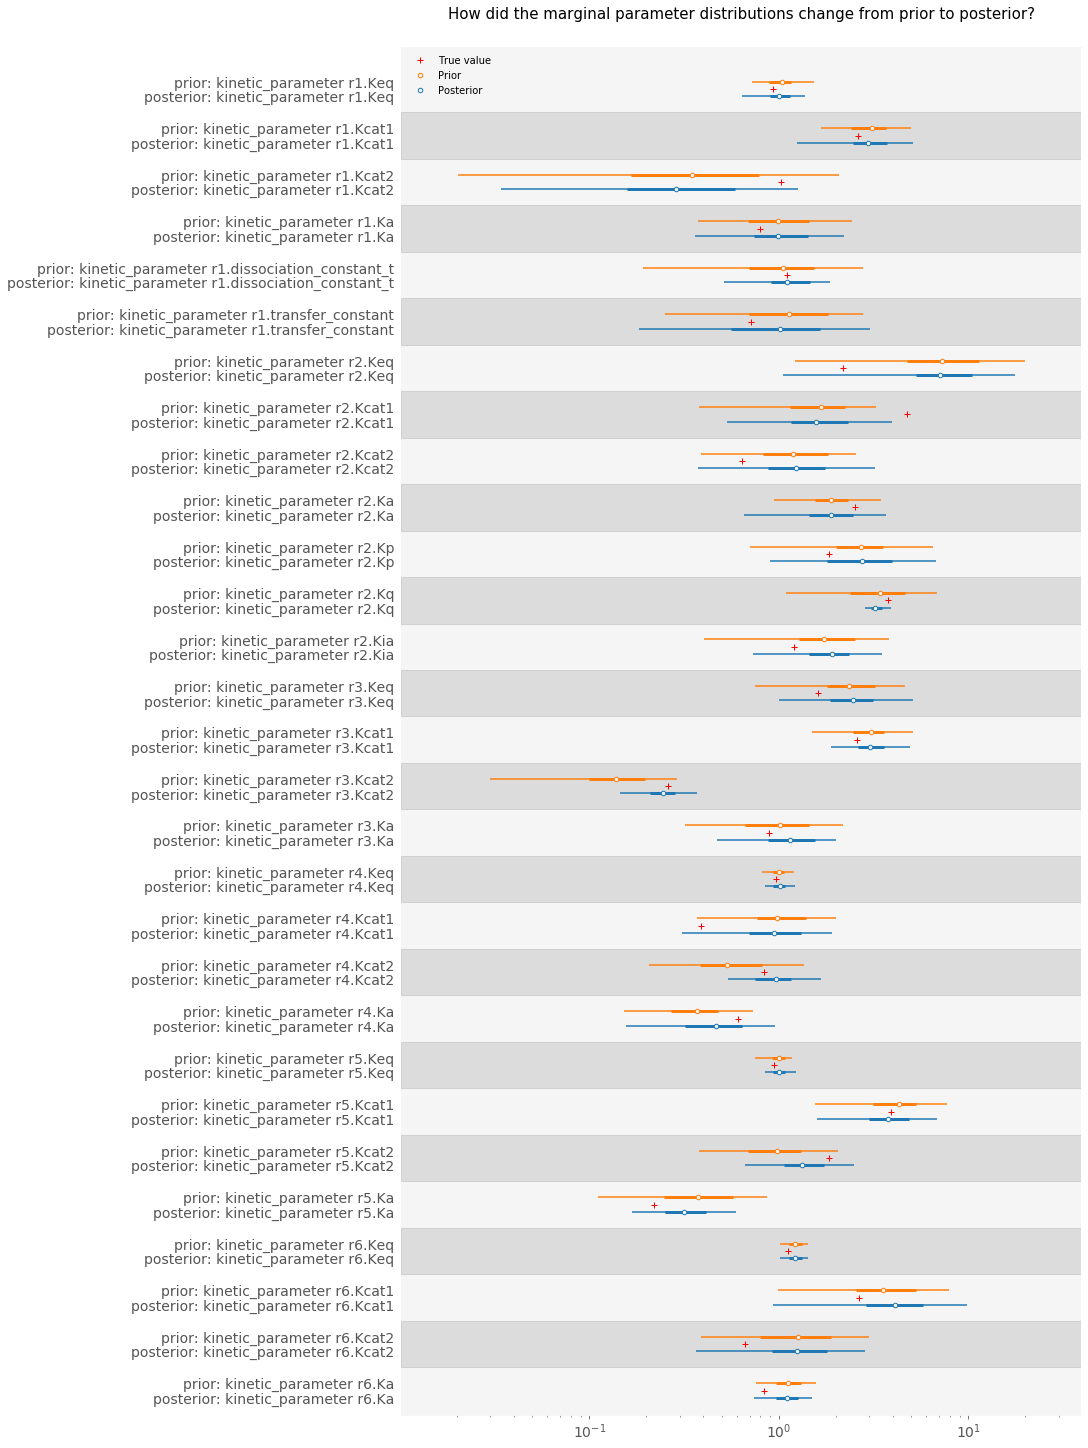

In [9]:
f, [ax] = arviz.plot_forest(
    [infd_prior, infd_posterior],
    combined=True,
    model_names=['prior', 'posterior'],
    var_names=['kinetic_parameter'],
    figsize=[15, 20],
    colors=['tab:orange', 'tab:blue']
)
t = ax.set_title('How did the marginal parameter distributions change from prior to posterior?', fontsize=15)
lines = [l for axis in f.axes for l in axis.get_lines()]
for l, true_value in zip(lines[::-2], rn.kinetic_parameters['true_value'].tolist()):
    y = l.get_ydata()[0] - 1.15
    p = ax.plot(true_value, y, '+', color='r')
ax.legend([p[0], lines[1], lines[0]], ['True value', 'Prior', 'Posterior'], frameon=False, loc='upper left')
ax.semilogx()
plt.show()

The next cell makes a similar plot for the observed metabolite concentrations. Here the convergence towards the true value from prior to posterior is much higher than for the marginal parameter distributions. 

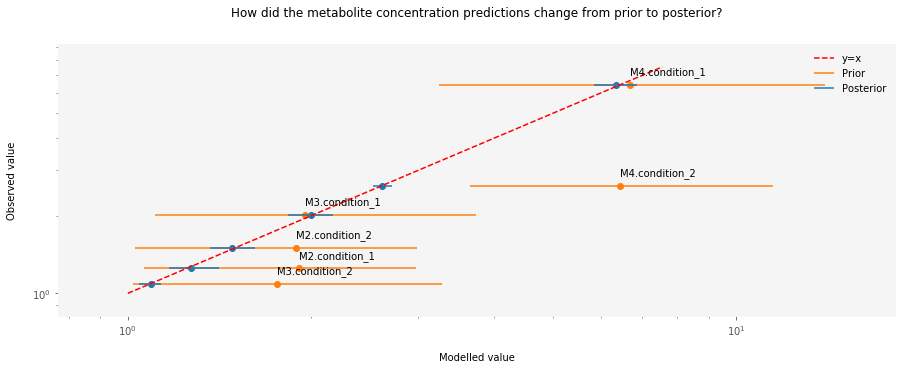

In [10]:
posterior_low, posterior_med, posterior_high = (
    infd_posterior.posterior_predictive['simulated_concentration_measurement'].quantile(q, dim=['chain', 'draw'])
    for q in [0.1, 0.5, 0.9]
)
prior_low, prior_med, prior_high = (
    infd_prior.posterior_predictive['simulated_concentration_measurement'].quantile(q, dim=['chain', 'draw'])
    for q in [0.1, 0.5, 0.9]
)
obs = infd_posterior.observed_data['simulated_concentration_measurement']
x = np.linspace(infd_posterior.posterior_predictive['simulated_concentration_measurement'].min(), 
                infd_posterior.posterior_predictive['simulated_concentration_measurement'].max(), 100)
labels = posterior_med.coords['concentration_measurements']

f, ax = plt.subplots(figsize=[15, 5])

ax.scatter(prior_med, obs, label='', color='tab:orange')
ax.hlines(obs, prior_low, prior_high, color='tab:orange', label='Prior')

ax.scatter(posterior_med, obs, label='', color='tab:blue')
ax.hlines(obs, posterior_low, posterior_high, color='tab:blue', label='Posterior', alpha=1)
for label, observed_value, prior_med_value in zip(labels.values, obs.values, prior_med.values):
    ax.text(prior_med_value, observed_value * 1.1, label)


ax.plot(x, x, color='r', linestyle='--', label='y=x')
ax.semilogx()
ax.semilogy()
legend = ax.legend(frameon=False)
text = ax.set(title='How did the metabolite concentration predictions change from prior to posterior?',
              xlabel='Modelled value',
              ylabel='Observed value')

Finally, the following plot shows the posterior correlation between each parameter. We can see that although there are some correlations, there are no troubling funnel or banana shapes.

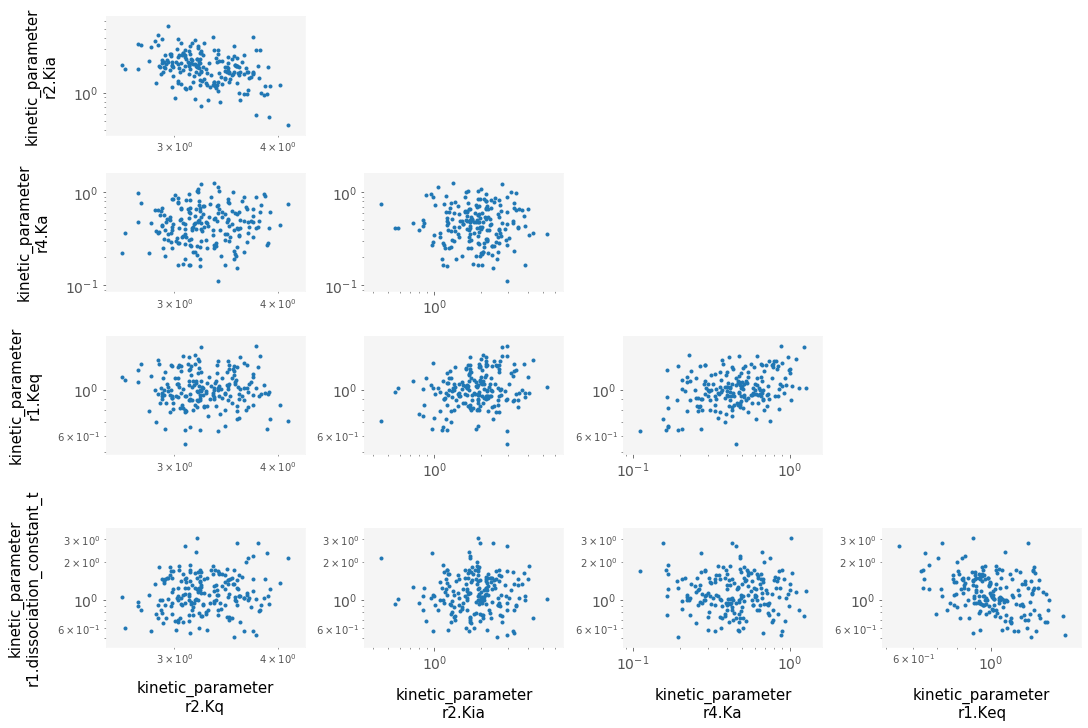

In [11]:
correlations = (
    infd_posterior.posterior['kinetic_parameter']
    .to_series()
    .unstack()
    .corr()
    .where(lambda df: np.tril(np.ones(df.shape), k=-1).astype(bool))
    .stack()
)
biggest_correlations = (
    correlations
    .reindex(correlations.abs().sort_values(ascending=False).index)
    .head(3)
    .index
    .values
    .tolist()
)

params_with_correlations = list(reduce(lambda a, b: set(a).union(set(b)), biggest_correlations))


axes = arviz.plot_pair(infd_posterior, 
                       var_names=['kinetic_parameter'], 
                       coords={'parameter_names': params_with_correlations},
                       figsize=[15, 10])
for ax in plt.gcf().get_axes():
    ax.semilogx()
    ax.semilogy()

## Acknowledgements
The research was produced as part of the project '[Quantitative modelling of cell metabolism](https://www.biosustain.dtu.dk/research/scientific-sections/quantitative-modelling-of-cell-metabolism)', which is part of the DTU Biosustain department and is funded by the [Novo Nordisk Foundation](https://novonordiskfonden.dk/en/).


## References

Cleland, W. W. 1963. “The Kinetics of Enzyme-Catalyzed Reactions with Two or More Substrates or Products: I. Nomenclature and Rate Equations.” _Biochimica et Biophysica Acta (BBA) - Specialized Section on Enzymological Subjects 67_ (January): 104–37. doi:10.1016/0926-6569(63)90211-6.

Popova, S. V., and E. E. Sel’kov. 1975. “Generalization of the Model by Monod, Wyman and Changeux for the Case of a Reversible Monosubstrate Reaction.” _FEBS Letters_ 53 (3): 269–73. doi:10.1016/0014-5793(75)80034-2.

Saa, Pedro A., and Lars K. Nielsen. 2016. “Construction of Feasible and Accurate Kinetic Models of Metabolism: A Bayesian Approach.” _Scientific Reports_ 6 (1). doi:10.1038/srep29635.

———. 2017. “Formulation, Construction and Analysis of Kinetic Models of Metabolism: A Review of Modelling Frameworks.” _Biotechnology Advances_ 35 (8): 981–1003. doi:10.1016/j.biotechadv.2017.09.005.

Tsigkinopoulou, Areti, Syed Murtuza Baker, and Rainer Breitling. 2017. “Respectful Modeling: Addressing Uncertainty in Dynamic System Models for Molecular Biology.” _Trends in Biotechnology_ 35 (6): 518–29. doi:10.1016/j.tibtech.2016.12.008.
